# Проект: классификация

In [399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [400]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [401]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [402]:
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [403]:
df['balance'] = df['balance'].apply(lambda x: float(str(x).replace(',','.').replace('$','').replace(' ','')))
df['balance'].mean()

1529.1290293615875

### Задание 4

In [404]:
df['balance'] = df['balance'].replace(np.NaN, df['balance'].median())
df['balance'].mean()

1526.9360329690019

### Задание 5

In [405]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df['job'] = df['job'].apply(lambda x: df['job'].value_counts().index[0] if x=='unknown' else x)
df['education'] = df['education'].apply(lambda x: df['education'].value_counts().index[0] if x=='unknown' else x)

In [406]:
round(df[df['job']==df['job'].value_counts().index[0]][df['education']==df['education'].value_counts().index[0]]['balance'].mean(),3)

1598.883

### Задание 6

<AxesSubplot: xlabel='balance'>

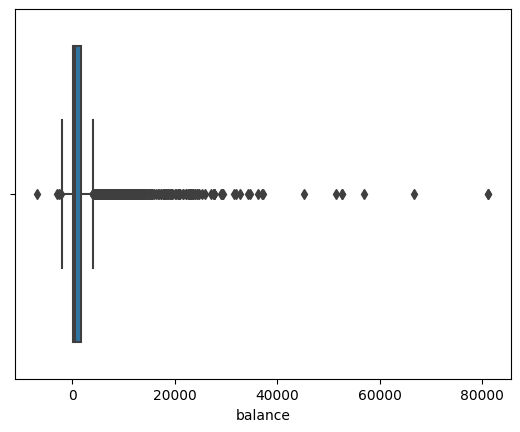

In [407]:
# удалите все выбросы для признака balance
sns.boxplot(df, x='balance')

In [408]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1 = x.quantile(0.25)
    quartile_3 = x.quantile(0.75) 
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    print(round(lower_bound,0))
    print(round(upper_bound,0))
    return outliers, cleaned

In [409]:
outliers_iqr(df, 'balance')

-2241.0
4063.0


(       age          job   marital  education default  balance housing loan  \
 60      51  blue-collar   married  secondary      no   7180.0     yes   no   
 61      41  blue-collar  divorced  secondary      no   5291.0     yes   no   
 69      44   technician   married   tertiary      no   4580.0     yes   no   
 71      29   management   married   tertiary      no  10576.0      no   no   
 86      54   management    single   tertiary      no   4393.0     yes   no   
 ...    ...          ...       ...        ...     ...      ...     ...  ...   
 11073   34  blue-collar   married    primary      no   6718.0      no   no   
 11077   54      retired  divorced   tertiary      no   6102.0     yes  yes   
 11085   60   technician   married    primary      no   4243.0     yes   no   
 11086   42       admin.   married  secondary      no   6445.0     yes   no   
 11101   54  blue-collar   married    primary      no   6242.0     yes   no   
 
         contact  day month  duration  campaign  p

In [410]:
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

-2241.0
4063.0
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


In [411]:
df_1 = cleaned

## Часть 2:  Разведывательный анализ

### Задание 1

<AxesSubplot: >

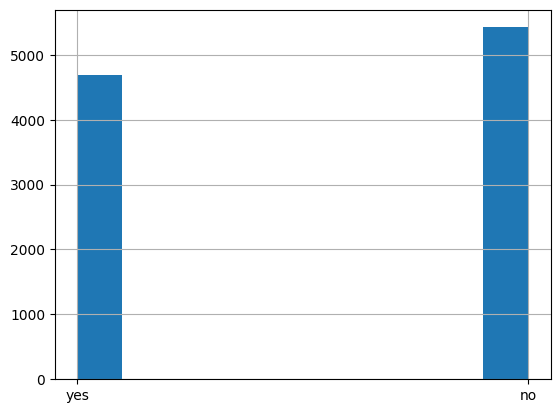

In [412]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
df_1['deposit'].hist()

In [413]:
df_1['deposit'].value_counts(normalize=True)

no     0.536764
yes    0.463236
Name: deposit, dtype: float64

In [414]:
df_1['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

### Задания 2 и 3

In [415]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df_1.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


<AxesSubplot: >

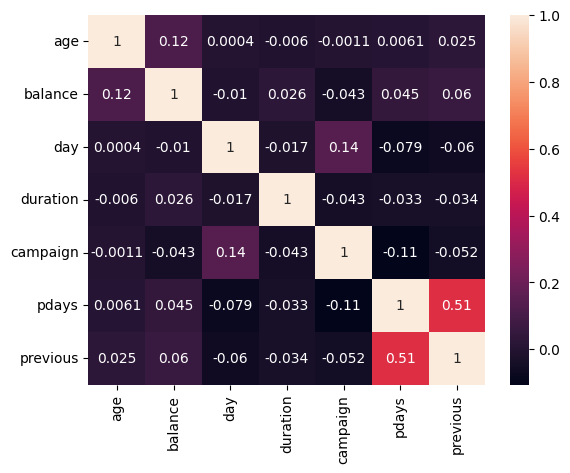

In [416]:
sns.heatmap(df_1.corr(), annot=True)

array([[<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'balance'}>,
        <AxesSubplot: title={'center': 'day'}>],
       [<AxesSubplot: title={'center': 'duration'}>,
        <AxesSubplot: title={'center': 'campaign'}>,
        <AxesSubplot: title={'center': 'pdays'}>],
       [<AxesSubplot: title={'center': 'previous'}>, <AxesSubplot: >,
        <AxesSubplot: >]], dtype=object)

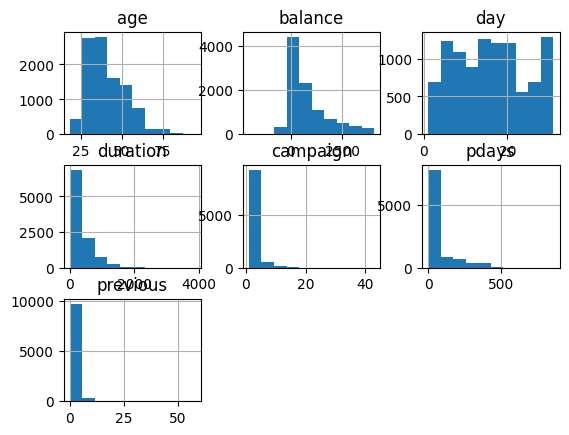

In [417]:
df_1.hist()

### Задания 4 и 5

In [418]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df_1.describe(include = 'object')
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


array([[<AxesSubplot: xlabel='age', ylabel='age'>,
        <AxesSubplot: xlabel='balance', ylabel='age'>,
        <AxesSubplot: xlabel='day', ylabel='age'>,
        <AxesSubplot: xlabel='duration', ylabel='age'>,
        <AxesSubplot: xlabel='campaign', ylabel='age'>,
        <AxesSubplot: xlabel='pdays', ylabel='age'>,
        <AxesSubplot: xlabel='previous', ylabel='age'>],
       [<AxesSubplot: xlabel='age', ylabel='balance'>,
        <AxesSubplot: xlabel='balance', ylabel='balance'>,
        <AxesSubplot: xlabel='day', ylabel='balance'>,
        <AxesSubplot: xlabel='duration', ylabel='balance'>,
        <AxesSubplot: xlabel='campaign', ylabel='balance'>,
        <AxesSubplot: xlabel='pdays', ylabel='balance'>,
        <AxesSubplot: xlabel='previous', ylabel='balance'>],
       [<AxesSubplot: xlabel='age', ylabel='day'>,
        <AxesSubplot: xlabel='balance', ylabel='day'>,
        <AxesSubplot: xlabel='day', ylabel='day'>,
        <AxesSubplot: xlabel='duration', ylabel='day'>,
 

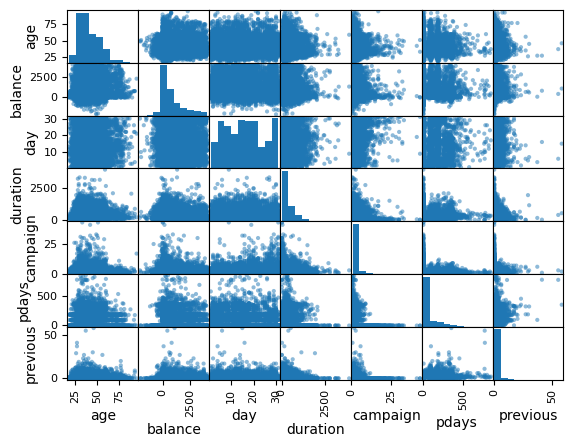

In [419]:
pd.plotting.scatter_matrix(df_1)

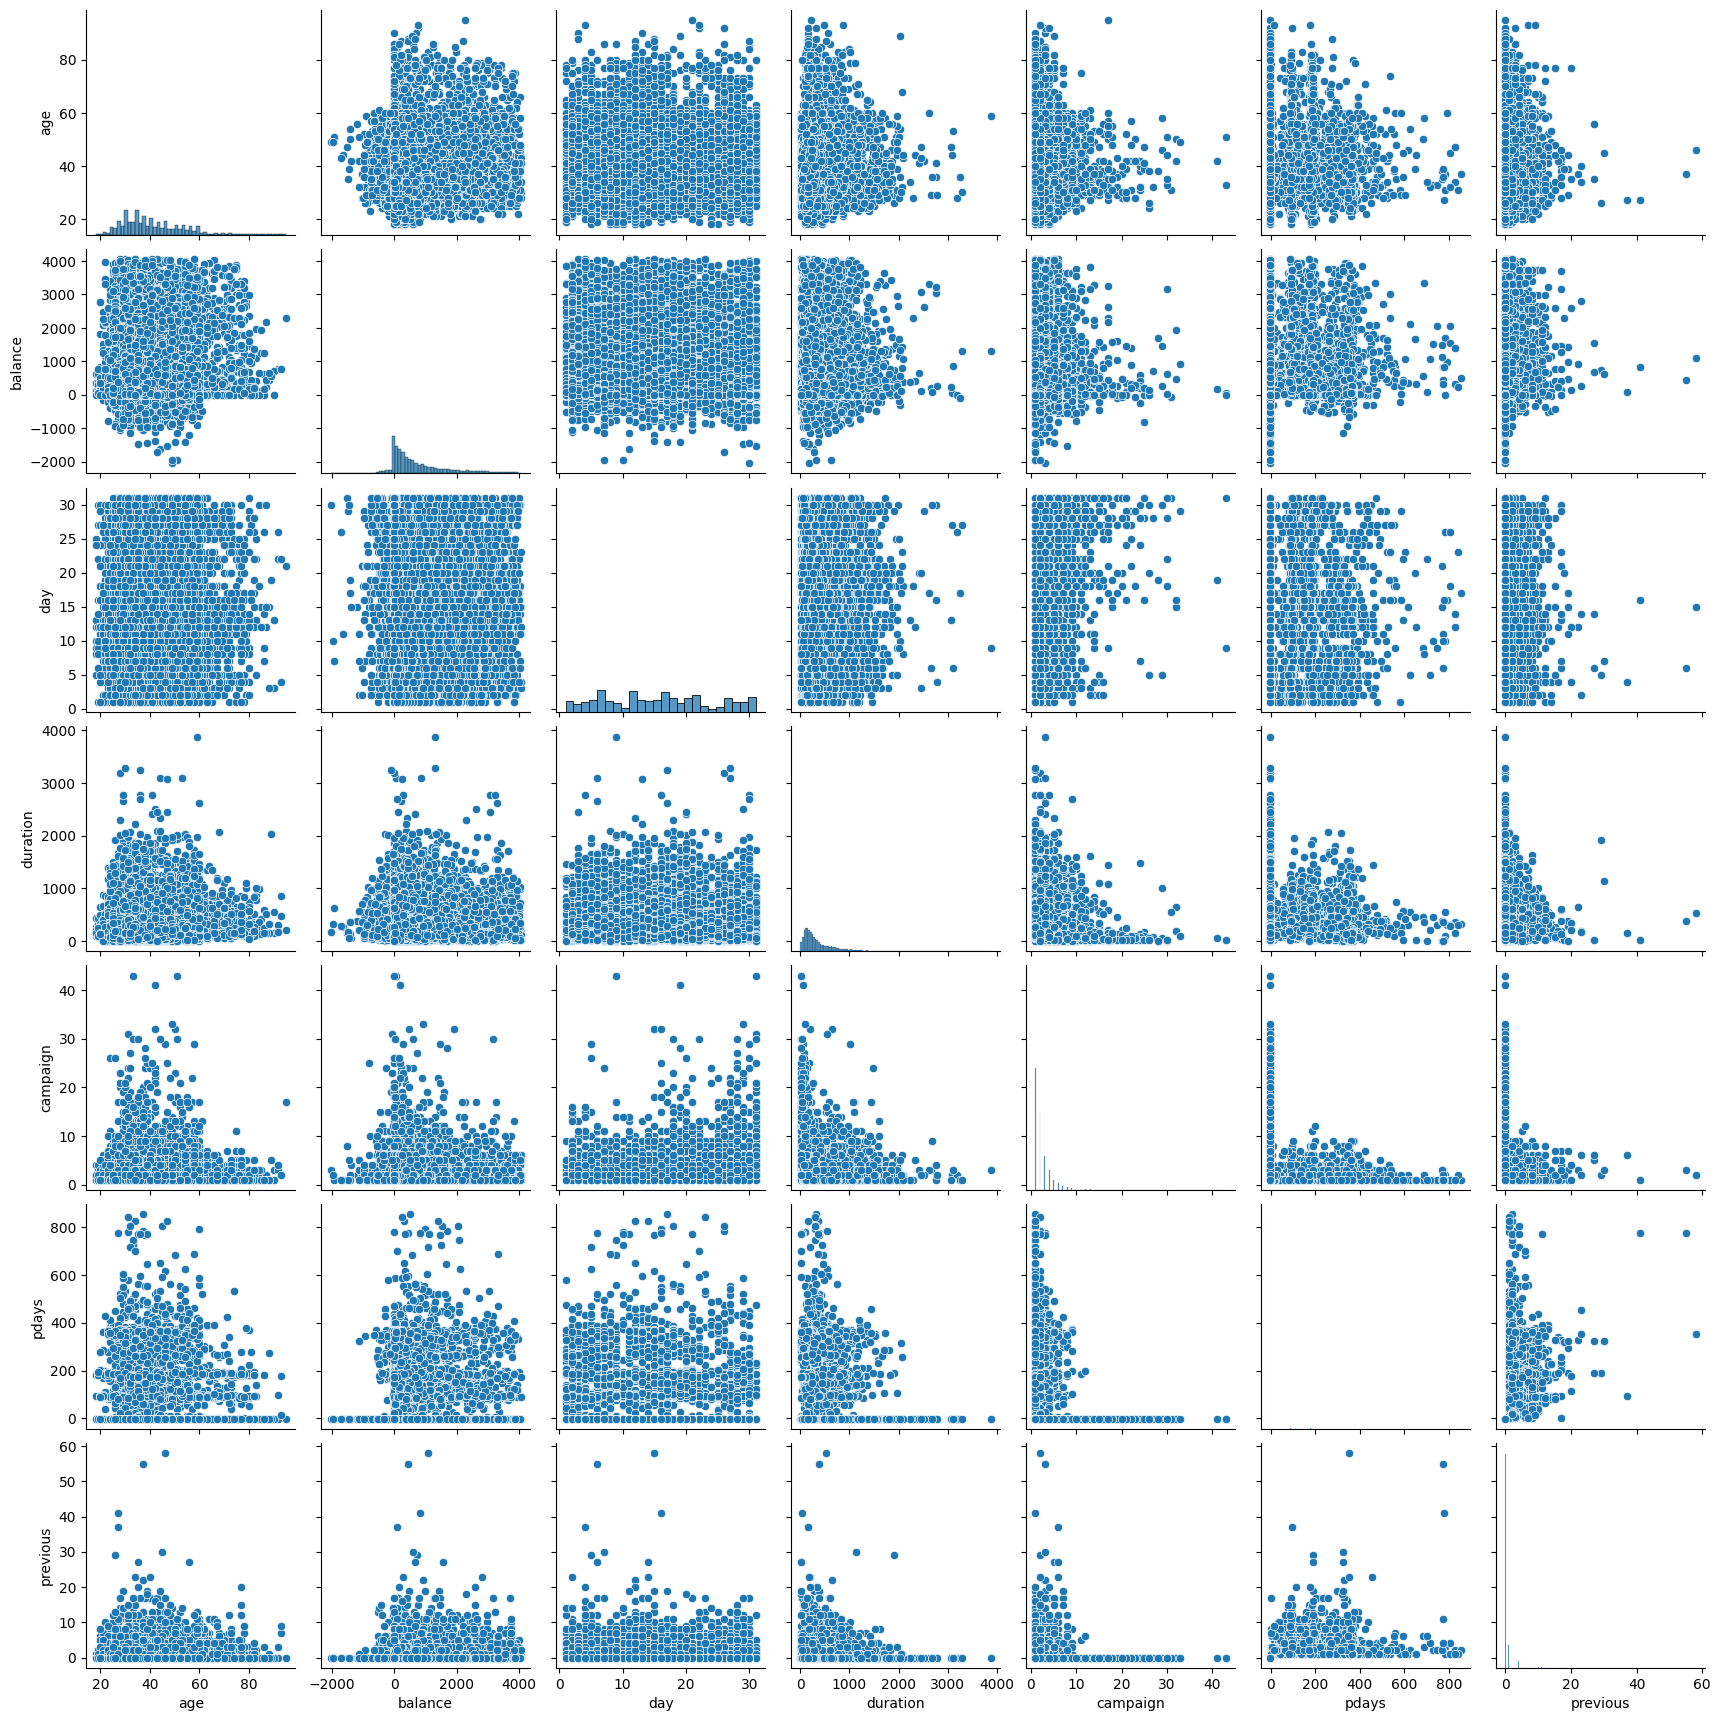

In [420]:
sns.pairplot(df_1)

job	marital	education	default	housing	loan	contact	month	poutcome	deposit

<AxesSubplot: >

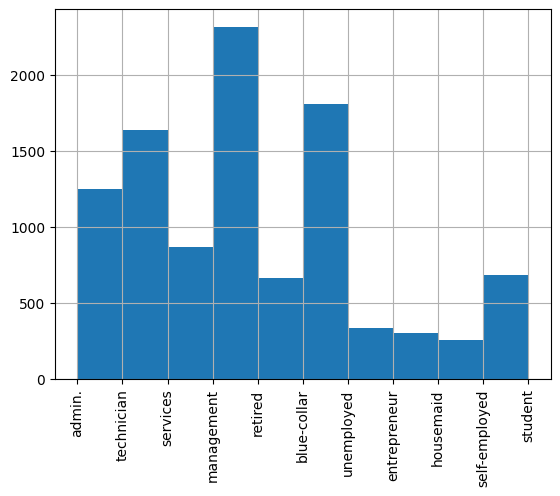

In [421]:
df_1['job'].hist(xrot=90)

<AxesSubplot: >

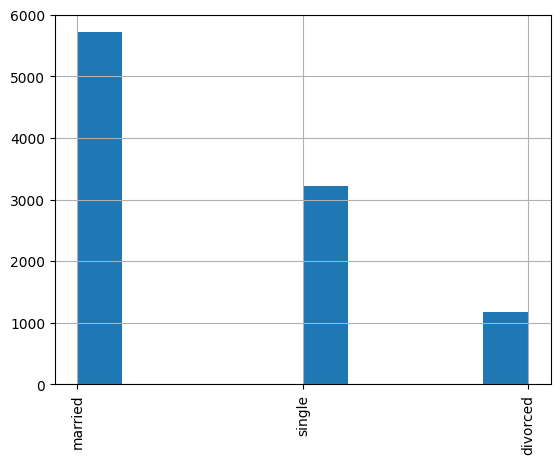

In [422]:
df_1['marital'].hist(xrot=90)

<AxesSubplot: >

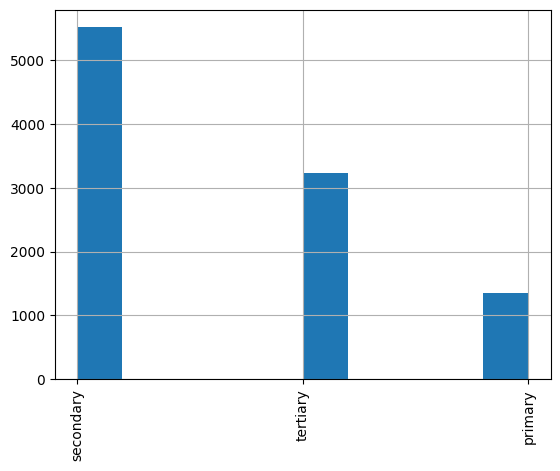

In [423]:
df_1['education'].hist(xrot=90)

<AxesSubplot: >

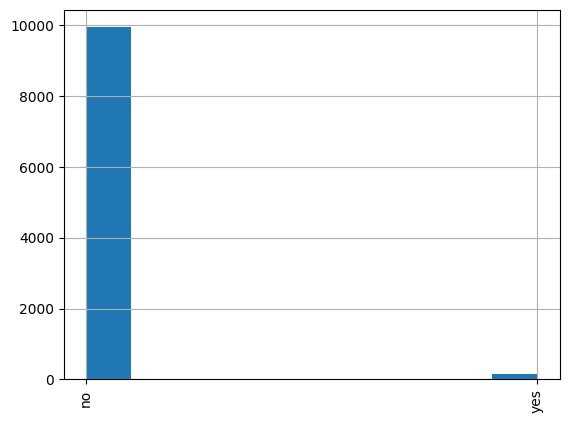

In [424]:
df_1['default'].hist(xrot=90)

<AxesSubplot: >

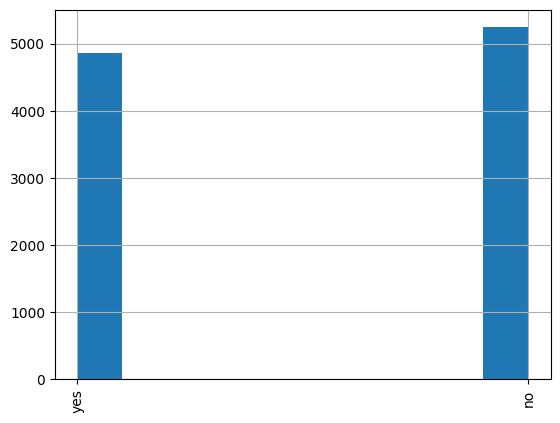

In [425]:
df_1['housing'].hist(xrot=90)

<AxesSubplot: >

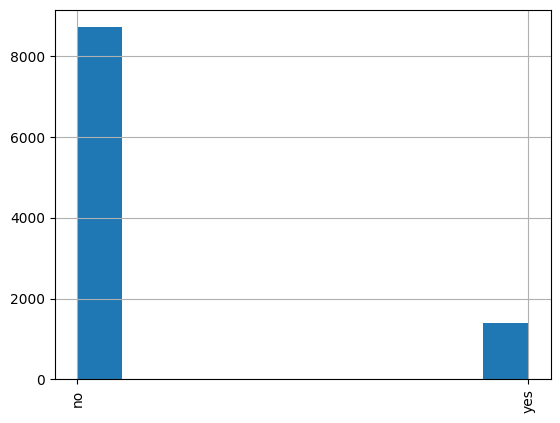

In [426]:
df_1['loan'].hist(xrot=90)

<AxesSubplot: >

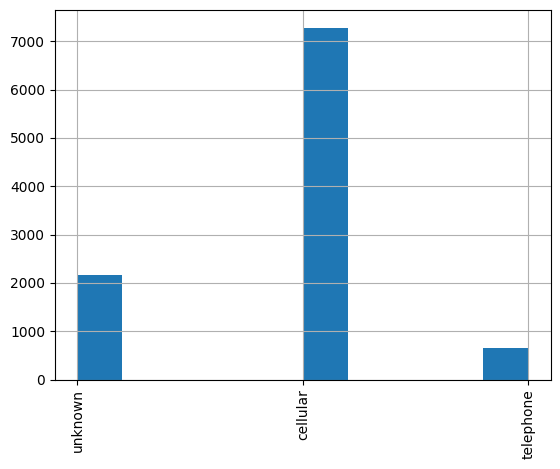

In [427]:
df_1['contact'].hist(xrot=90)

<AxesSubplot: >

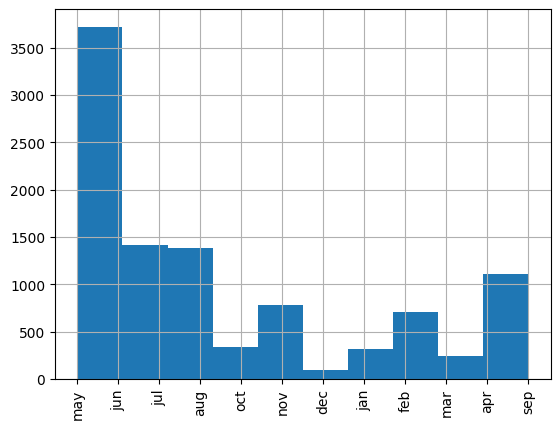

In [428]:
df_1['month'].hist(xrot=90)

<AxesSubplot: >

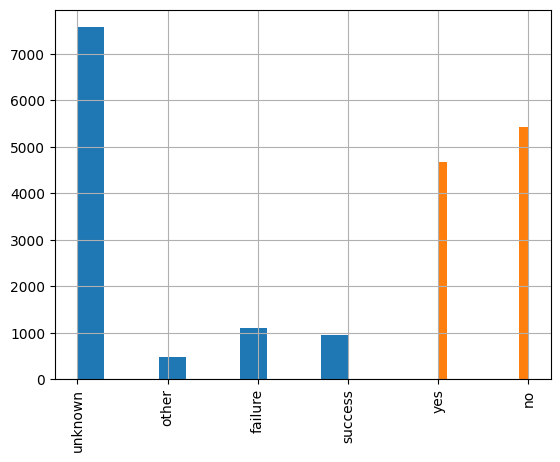

In [429]:
df_1['poutcome'].hist(xrot=90)
df_1['deposit'].hist(xrot=90)

In [430]:
df_1['month'].value_counts()

may    2617
jul    1418
aug    1385
jun    1104
apr     830
nov     780
feb     709
oct     335
jan     319
sep     278
mar     237
dec      93
Name: month, dtype: int64

### Задание 6

In [431]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код

### Задание 7

In [432]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df_1.groupby(by='month')['deposit'].value_counts(normalize=True).sort_values(ascending=False)

month  deposit
dec    yes        0.903226
mar    yes        0.898734
sep    yes        0.834532
oct    yes        0.814925
may    no         0.678640
apr    yes        0.618072
jan    no         0.608150
jul    no         0.589563
nov    no         0.584615
aug    no         0.559567
jun    no         0.548913
feb    yes        0.544429
       no         0.455571
jun    yes        0.451087
aug    yes        0.440433
nov    yes        0.415385
jul    yes        0.410437
jan    yes        0.391850
apr    no         0.381928
may    yes        0.321360
oct    no         0.185075
sep    no         0.165468
mar    no         0.101266
dec    no         0.096774
Name: deposit, dtype: float64

### Задание 8

In [433]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def age_group(x):
    if x<30:
        return '<30'
    if x<40:
        return '30-40'
    if x<50:
        return '40-50'
    if x<60:
        return '50-60'
    else:
        return '60+'
    
df_1['age_gr'] = df_1['age'].apply(age_group)
#df_1.drop('age',axis=1, inplace=True)
df_1.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_gr
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60
5,42,management,single,tertiary,no,0.0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes,40-50
6,56,management,married,tertiary,no,830.0,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes,50-60
7,60,retired,divorced,secondary,no,545.0,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes,60+
8,37,technician,married,secondary,no,1.0,yes,no,unknown,6,may,608,1,-1,0,unknown,yes,30-40
9,28,services,single,secondary,no,550.0,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes,<30


In [434]:
#import plotly.express as px
#sns.barplot(df_1.groupby(['age_gr'])['deposit'].count(), x='age_gr')

print(df_1.groupby(['age_gr', 'deposit'])['deposit'].count())

age_gr  deposit
30-40   no         2245
        yes        1716
40-50   no         1444
        yes         938
50-60   no          984
        yes         670
60+     no          157
        yes         496
<30     no          594
        yes         861
Name: deposit, dtype: int64


In [435]:
df_gr = pd.DataFrame(df_1.groupby(['age_gr', 'deposit'])['deposit'].count().reset_index(name='Count'))
df_gr

,age_gr,deposit,Count
0,30-40,no,2245
1,30-40,yes,1716
2,40-50,no,1444
3,40-50,yes,938
4,50-60,no,984
5,50-60,yes,670
6,60+,no,157
7,60+,yes,496
8,<30,no,594
9,<30,yes,861


In [436]:
import plotly.express as px
 
fig = px.bar(df_gr, x = "age_gr", y = "Count",
             color = "deposit", title = "Deposit success",
             barmode="group")
fig.show()

### Задания 9 и 10

In [437]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = px.bar(pd.DataFrame(df_1.groupby(['marital', 'deposit'])['deposit'].count().reset_index(name='Count')), x = "marital", y = "Count",
             color = "deposit", title = "Deposit success",
             barmode="group")
fig.show()


In [438]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = px.bar(pd.DataFrame(df_1.groupby(['education', 'deposit'])['deposit'].count().reset_index(name='Count')), x = "education", y = "Count",
             color = "deposit", title = "Deposit success",
             barmode="group")
fig.show()

In [439]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

fig = px.bar(pd.DataFrame(df_1.groupby(['job', 'deposit'])['deposit'].count().reset_index(name='Count')), x = "job", y = "Count",
             color = "deposit", title = "Deposit success",
             barmode="group")
fig.show()

### Задание 11

<AxesSubplot: xlabel='marital', ylabel='education'>

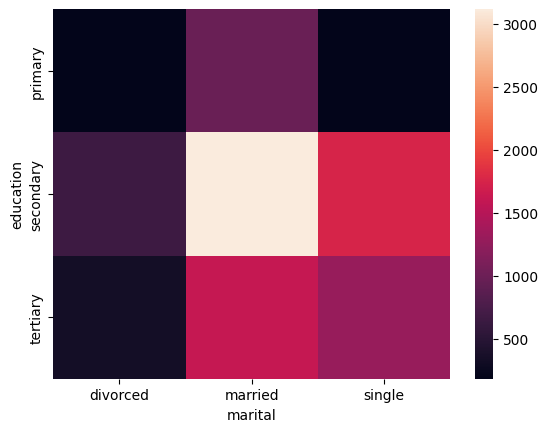

In [440]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

sns.heatmap(df_1.pivot_table(
    values='default',
    index='education',
    columns='marital',
    aggfunc='count'
))

## Часть 3: преобразование данных

### Задание 1

In [441]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
df_1['education'] = labelencoder.fit_transform(df_1['education'])

In [442]:
df_1['education'].sum()

11995

In [443]:
df_1['age_gr'] = labelencoder.fit_transform(df_1['age_gr'])

### Задания 2 и 3

In [444]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df_1['deposit'] = df_1['deposit'].apply(lambda x: 1 if x=='yes' else 0)
df_1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_gr
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,1,2


In [445]:
round(df_1['deposit'].std(),3)

0.499

In [446]:
df_1['default'] = df_1['default'].apply(lambda x: 1 if x=='yes' else 0)
df_1['housing'] = df_1['housing'].apply(lambda x: 1 if x=='yes' else 0)
df_1['loan'] = df_1['loan'].apply(lambda x: 1 if x=='yes' else 0)

In [447]:
df_1.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_gr
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


In [448]:
ex_4_3 = df_1['default'].mean() + df_1['housing'].mean() + df_1['loan'].mean()
round(ex_4_3, 3)

0.635

### Задание 4

In [449]:
# создайте дамми-переменные
df_2 = df_1.copy()
df_2 = pd.get_dummies(df_2, prefix='job', columns=['job'])
df_2 = pd.get_dummies(df_2, prefix='marital', columns=['marital'])
df_2 = pd.get_dummies(df_2, prefix='contact', columns=['contact'])
df_2 = pd.get_dummies(df_2, prefix='month', columns=['month'])
df_2 = pd.get_dummies(df_2, prefix='poutcome', columns=['poutcome'])

In [450]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_gr             10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

<AxesSubplot: >

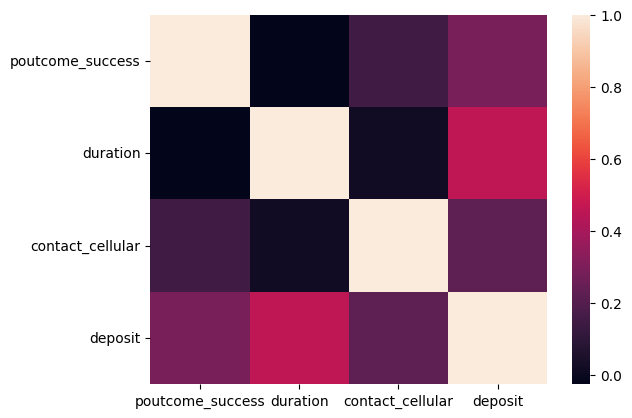

In [451]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
sns.heatmap(df_2[['poutcome_success', 'duration', 'contact_cellular', 'deposit']].corr())

<AxesSubplot: >

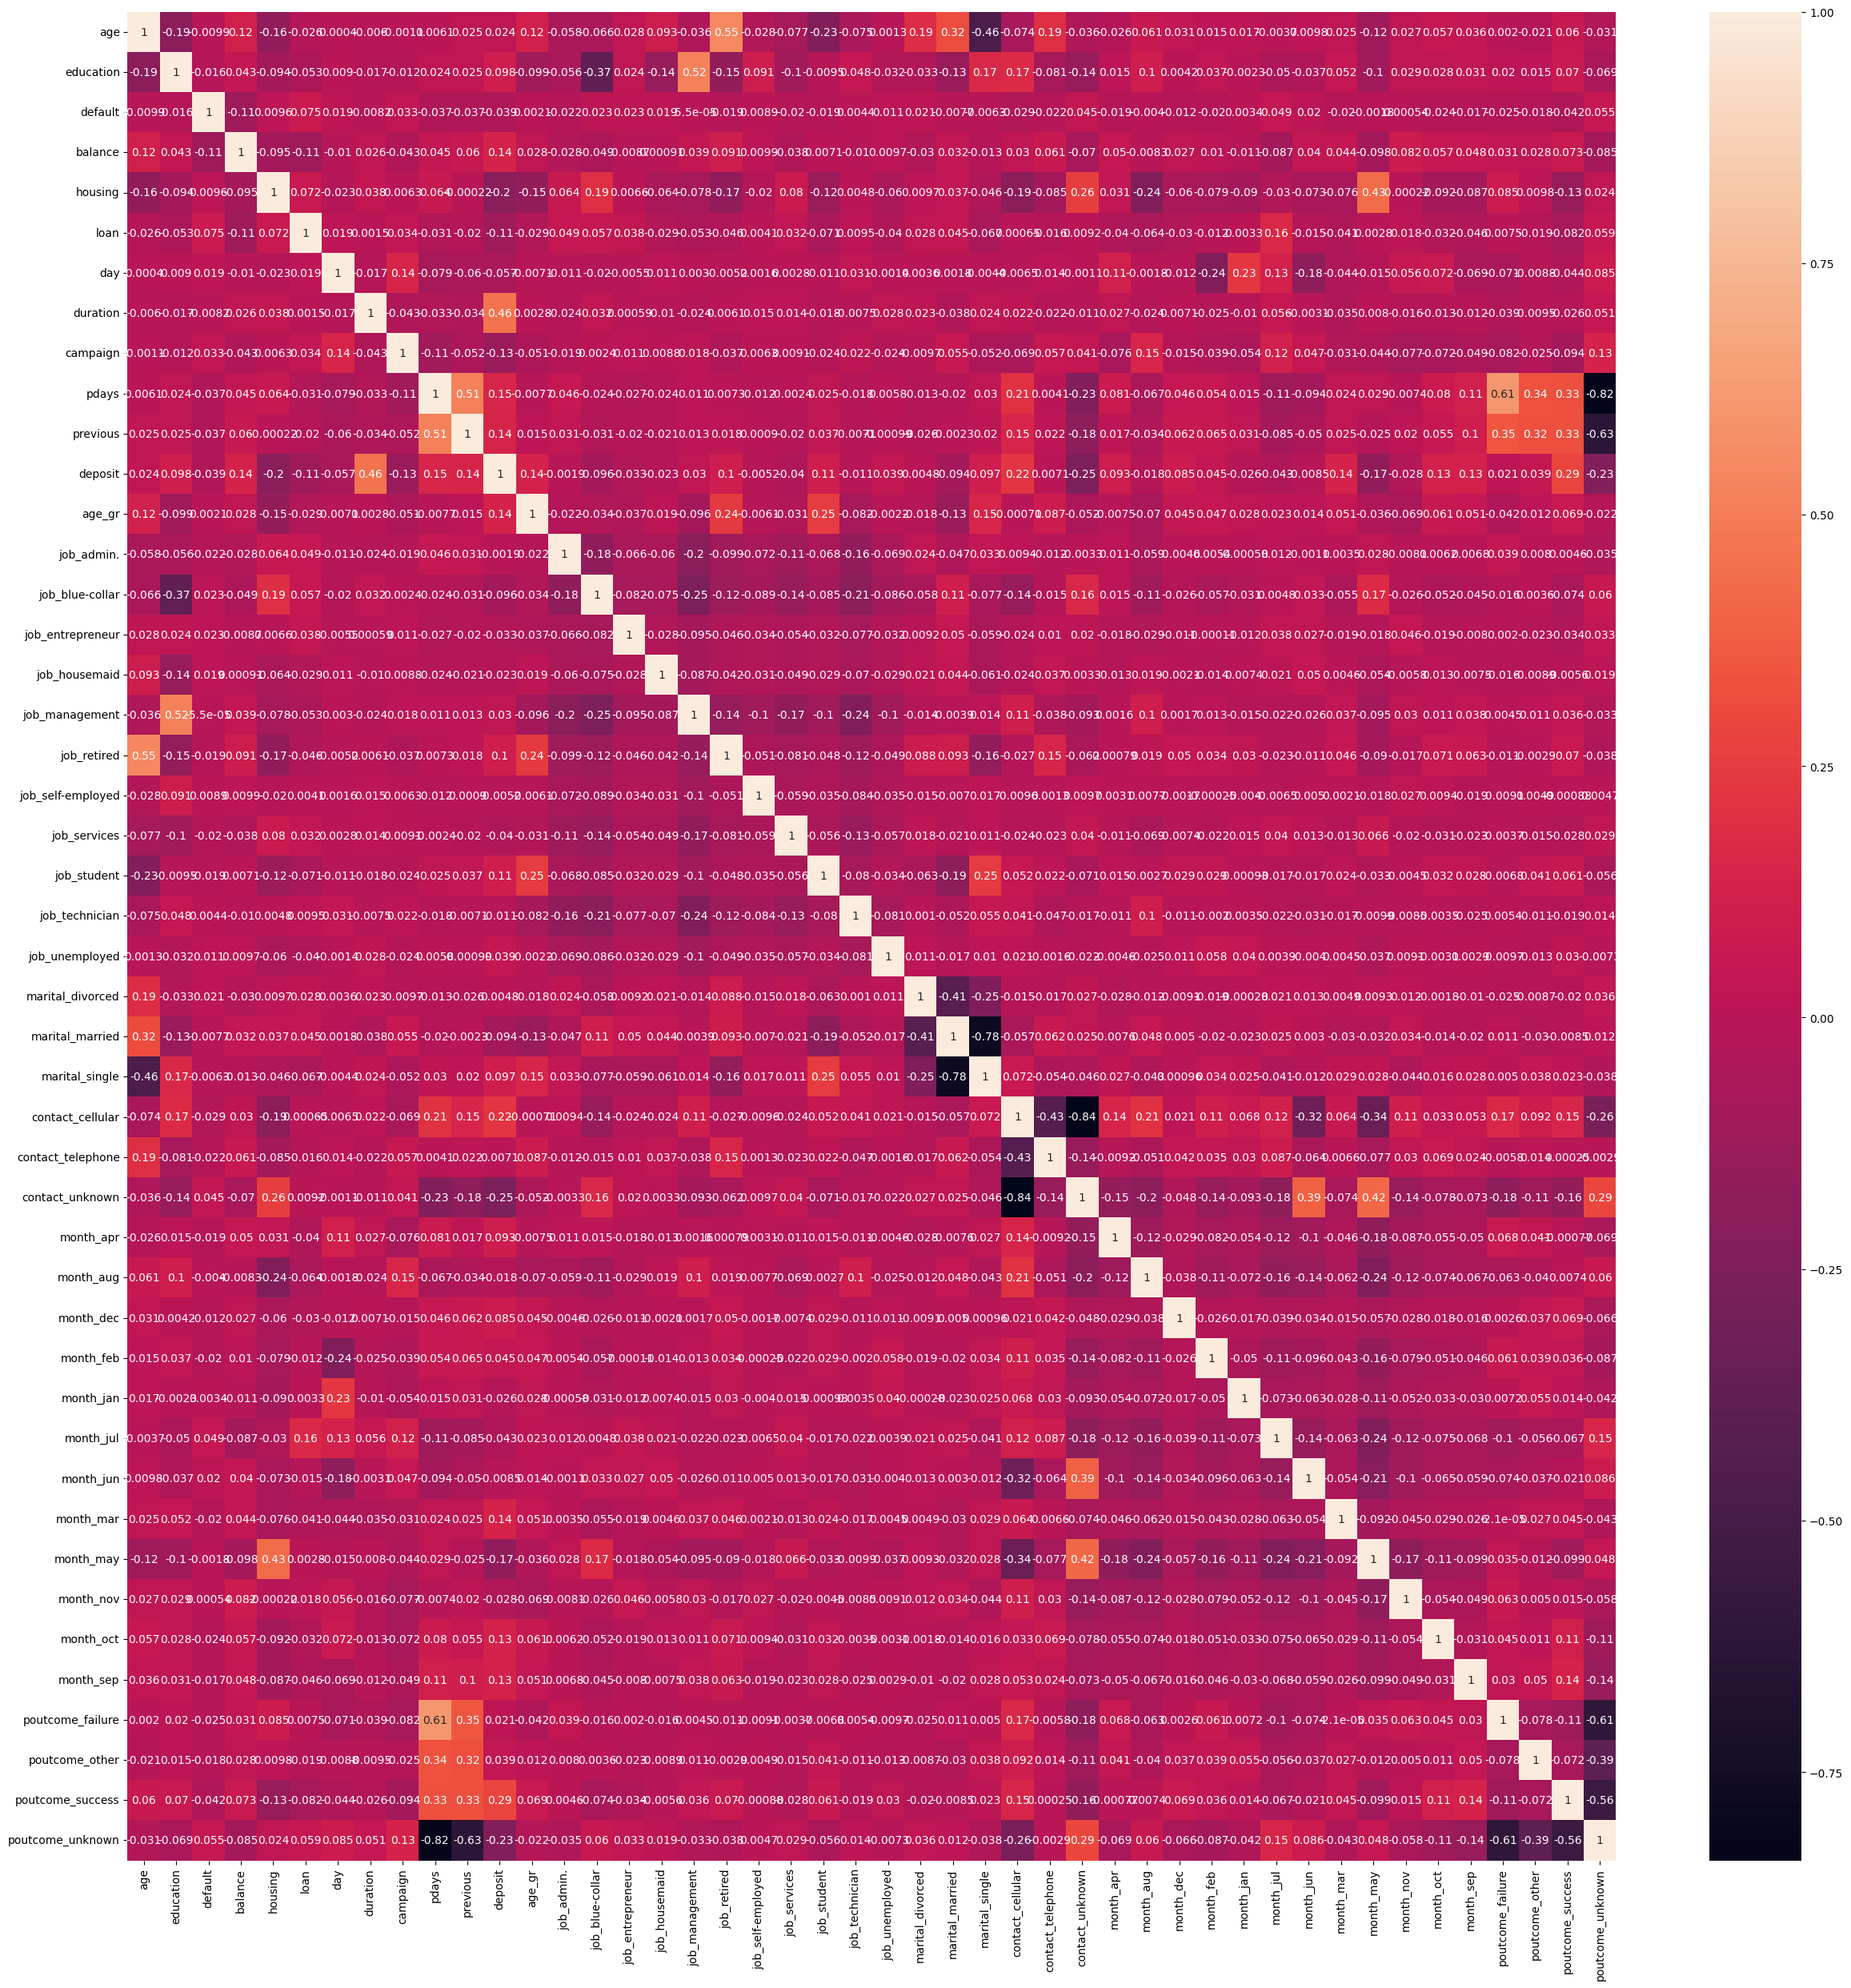

In [452]:
#set heatmap size
import matplotlib.pyplot as plt
plt.figure(figsize = (30,30))

#create heatmap
sns.heatmap(df_2.corr(), annot=True) 

### Задания 7 и 8

In [453]:
X = df_2.drop(['deposit'], axis=1)
y = df_2['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [454]:
# рассчитайте необходимые показатели
X_test.shape

(3335, 45)

In [455]:
round(y_test.mean(),2)

0.46

### Задание 9

In [456]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# Отбор реализуйте по обучающей выборке, используя параметр score_func = f_classif.
# Помните, что на данном этапе вам необходимо оставить только те признаки, которые содержат лишь числовые значения.

selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_gr', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [457]:
X_train_short = X_train[selector.get_feature_names_out()]
X_test_short = X_test[selector.get_feature_names_out()]

### Задание 10

In [458]:
# нормализуйте данные с помощью minmaxsxaler

# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train_short)
X_train_scaled = mm_scaler.transform(X_train_short)
X_test_scaled = mm_scaler.transform(X_test_short)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_short.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_short.columns)

In [459]:
round(X_test_scaled[:,0].mean(),2)

InvalidIndexError: (slice(None, None, None), 0)

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [ ]:
# обучите логистическую регрессию и рассчитайте метрики качества

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag',
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Рассчитываем F1-меру для тестовой выборки
print('Accuracy score test: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy score test: 0.805


### Задания 2,3,4

In [ ]:
# обучите решающие деревья, настройте максимальную глубину

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #используем энтропию Шеннона
    random_state=42
)

#Обучаем дерево решений на тренировочной выборке
dt_clf.fit(X_train_scaled, y_train)

#Делаем предсказание класса для тренировочного набора данных
y_train_pred = dt_clf.predict(X_train_scaled)
#Выводим значение F1-меры для тренировочного набора данных
print('F1_score train: ',metrics.f1_score(y_train, y_train_pred))

#Делаем предсказание класса для тестового набора данных
y_test_pred = dt_clf.predict(X_test_scaled)
#Выводим значение F1-меры для тестового набора данных
print('F1_score test: ',metrics.f1_score(y_test, y_test_pred))

F1_score train:  1.0
F1_score test:  0.7220573689416419


In [ ]:
print(dt_clf.tree_.max_depth)

36


In [ ]:
#Создаём список из 20 возможных значений от 0.001 до 1
max_depths = np.arange(1, 37, 1)
#Создаём пустые списки, в которые будем добавлять результаты 
train_scores = []
test_scores = []
for depth in max_depths:
    #Создаём объект класса дерево решений
    dt_clf = tree.DecisionTreeClassifier(
        criterion='entropy', #используем энтропию Шеннона
        random_state=42,
        max_depth=depth
    )
    #Обучаем модель
    dt_clf.fit(X_train_scaled, y_train)
    #Делаем предсказание для тренировочной выборки
    y_train_predict = dt_clf.predict(X_train_scaled)
    #Делаем предсказание для тестовой выборки
    y_test_predict = dt_clf.predict(X_test_scaled)
    #Рассчитываем метрики Accuracy для двух выборок и добавляем их в списки
    train_scores.append(metrics.accuracy_score(y_train, y_train_predict))
    test_scores.append(metrics.accuracy_score(y_test, y_test_predict))

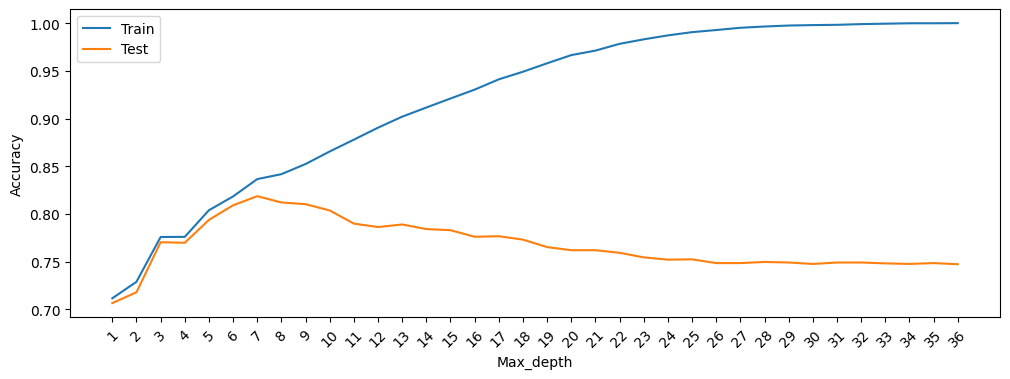

In [ ]:
#Визуализируем изменение Accuracy в зависимости от max_depth
fig, ax = plt.subplots(figsize=(12, 4)) #фигура + координатная плоскость
ax.plot(max_depths, train_scores, label='Train') #линейный график для тренировочной выборки
ax.plot(max_depths, test_scores, label='Test') #линейный график для тестовой выборки
ax.set_xlabel('Max_depth') #название оси абсцисс
ax.set_ylabel('Accuracy') #название оси ординат
ax.set_xticks(max_depths) #метки по оси абсцисс
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс
ax.legend(); #отображение легенды

### Задание 5

In [ ]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10],
              'max_depth':[3,5,7]
              }
            
grid_search_tree = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid = param_grid, 
    )  
grid_search_tree.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search_tree.score(X_test_scaled, y_test)))
y_test_pred = grid_search_tree.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.4f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_tree.best_params_))

accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.8015
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [ ]:
# обучите на ваших данных случайный лес

#Создаём объект класса случайный лес
rf_clf_2d = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf = 5,
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf_2d.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred = rf_clf_2d.predict(X_test_scaled)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [ ]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    min_samples_leaf = 5,
    learning_rate = 0.05,
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_test_pred = gb.predict(X_test_scaled)

# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [ ]:
# объедините уже известные вам алгоритмы с помощью стекинга 

from sklearn.ensemble import StackingClassifier

# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('dtc', tree.DecisionTreeClassifier()),
    ('lr', linear_model.LogisticRegression()),
    ('gbc', GradientBoostingClassifier())
]

# Создаем объект класса стекинг
reg = StackingClassifier(
    estimators=estimators,
    final_estimator=linear_model.LogisticRegression()
)
# Обучаем модель
reg.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred_stack = reg.predict(X_test_scaled)
# Оцениваем качество по метрике MSE
#print(f'Качество предсказания по MSE для стекинга {round(mean_squared_error(y_test, y_pred_stack), 2)}')
metrics.precision_score(y_test, y_pred_stack)

0.8115284974093264

### Задание 5

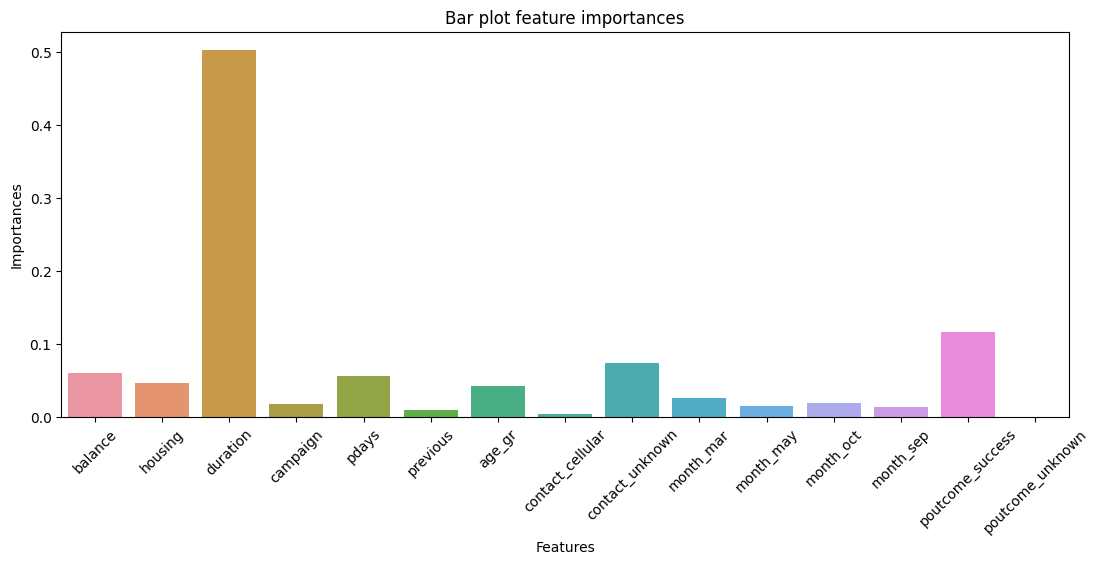

In [462]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_train_scaled.columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
ax.xaxis.set_tick_params(rotation=45) #поворот меток на оси абсцисс

### Задания 6,7,8

In [463]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  

In [466]:
import optuna

# %%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=100)

[I 2023-08-06 15:42:34,893] A new study created in memory with name: RandomForestClassifier


[I 2023-08-06 15:42:36,559] Trial 0 finished with value: 0.8927789934354486 and parameters: {'n_estimators': 178, 'max_depth': 22, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8927789934354486.
[I 2023-08-06 15:42:37,606] Trial 1 finished with value: 0.8473832654340332 and parameters: {'n_estimators': 154, 'max_depth': 13, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8473832654340332.
[I 2023-08-06 15:42:39,078] Trial 2 finished with value: 0.9103707179727828 and parameters: {'n_estimators': 157, 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8473832654340332.
[I 2023-08-06 15:42:40,051] Trial 3 finished with value: 0.8407623247755551 and parameters: {'n_estimators': 153, 'max_depth': 10, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.8407623247755551.
[I 2023-08-06 15:42:41,125] Trial 4 finished with value: 0.8458274398868458 and parameters: {'n_estimators': 168, 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 3 with value: 0.84

In [467]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 104, 'max_depth': 10, 'min_samples_leaf': 10}
f1_score на обучающем наборе: 0.84


In [469]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.81


_____________________________

In [471]:
y_true = [1.23, 2.35, 2.75]
y_pred = [1.01, 12.3, 2.74]

#import necessary libraries
from sklearn.metrics import mean_squared_error
from math import sqrt

#calculate RMSE
round(sqrt(mean_squared_error(y_true, y_pred)),2)

5.75